# Fruit and Vegetable Prices


## Data set selection

### Source (with link) 
The dataset comes from the USDA Economic Research Service – Fruit and Vegetable Prices Database.  
Link: https://www.ers.usda.gov/data-products/fruit-and-vegetable-prices/

---

### Fields

- **`Fruit`** – Name of the fruit  
- **`Form`** – The form in which the fruit is sold (Fresh, Canned, Juice, Frozen, etc.)  
- **`RetailPrice`** – Price per unit as sold (e.g., per pound, per pint)  
- **`RetailPriceUnit`** – Unit of pricing  
- **`Yield`** – Edible yield percentage after removing waste (peel, core, etc.)  
- **`CupEquivalentSize`** – How much product is needed to make 1 edible cup  
- **`CupEquivalentUnit`** – Unit used for the cup conversion  
- **`CupEquivalentPrice`** – Cost to obtain one edible cup of the fruit  

---

### License
Creative Commons CCZero  
Link: http://www.opendefinition.org/licenses/cc-zero

### Data set selection rationale

I selected this dataset because this dataset could provide real-world economic and nutrition data that are useful for health insights. It includes multiple variables that I can use for statistical analysis. The dataset is clean overall, I didn't have to preprocess it. By analyzing this dataset, I might be able to create analysis related to fruit affordability, and which fruits bring most value based on its price and yield.

### Questions to be answered
 - What is the price distribution of different fruits?  
 We can compare how fruit prices varies in cost  
 - What is the average retail price for different fresh fruits?  
 We can compare how fresh fruit prices vary in cost
 - What is the distribution of Fresh vs Frozen fruits retail price?
 We can compare Fresh fruit retail price and Frozen fruit retail price. Conducting independent sample t-test to contribute to findings
 - Is the form of fruits independent of its price category  
 This helps determine whether processing tends to make fruit more or less expensive
 - What is the relationship between retail price and cup equivalent price?  
 This helps understand how much edible fruit consumers actually get for the price they pay
 - How does yield impact the cost of edible fruit?
 This may answer if a fruit with low yield may be cheap per pound but be more expensive per serving
 - What is the distribution of fruit forms?
 This would answer which type of fruit products dominate the dataset. For stakeholders, it would help them understand what products consumers have access to.

### Visualization ideas
1. Histogram and box plot for the distribution of fruit prices. This would show how fruits generally vary across the dataset.
2. Interactive bar chart using Plotly for the average retail prices. This would show how fresh fruit prices vary across the dataset. By using Plotly, it would handle multiple labels of fruits on interacting with chart.  
3. Distribution comparison chart of Fresh vs Frozen form of fruits. This chart would help compare retail price between Fresh fruits vs Frozen fruits
4. Grouped bar chart for retail price vs form. This would show whether fresh or frozen form of chosen fruits tend to be cheaper or more expensive.  
5. Proportion bar chart for Price Category and Forms.
5. Scatter plot for retail price vs cup equivalent price. This would help identify correlation between retail price and cup equivalent price so that stakeholders can what fruits bring the good value. I would use plotly for this chart because that way, it allows to label which help stakeholders see exact price values, make correlation patterns clearer.  
6. Interative scatter plot for the impact of yield on cup equivalent price. This would show how edible yield affects how much the consumers pay. Low-yield fruit may seem cheap per pound but expensive per cup.   
7. Pie chart for distribution of fruit forms. This would help understand which types of fruit products dominate the dataset.



## Setup and Import Libraries

In [209]:
# 🚀 Importing some libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
  import plotly.express as px
  import plotly.graph_objects as go
  PLOTLY_AVAILABLE = True
except ImportError:
  PLOTLY_AVAILABLE = False
  print("Note: Plotly not available. Interactive visualizations will be skipped.")

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


## Visualization Style Setup

In [210]:
# =============================================================================
# VISUALIZATION STYLE SETUP
# =============================================================================
# Inspired from Professor Gilany's Visualization Style Setup
# Setting up consistent styling for all our charts
# Set default matplotlib parameters
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'normal',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'patch.linewidth': 0.5,
    'patch.edgecolor': 'white',
    'grid.linewidth': 0.8,
    'grid.alpha': 0.3
})
# Set the overall style
sns.set_style('whitegrid', {
    'grid.linestyle': '--',
    'grid.alpha': 0.3,
    'axes.edgecolor': '.2',
    'axes.linewidth': 1.2
})
sns.set_context('notebook', font_scale=1.1)

# Define a clean, modern color palette
sns.set_palette("pastel")

print("✅ Theme successfully loaded! All visualizations will use consistent styling.")

✅ Theme successfully loaded! All visualizations will use consistent styling.


## 📊 Loading the Data
Load the fruit and vegetable prices dataset

In [244]:
from pathlib import Path
import pandas as pd


def load_csv(path: Path) -> pd.DataFrame:
  try:
    df = pd.read_csv(path)
  except FileNotFoundError as e:
    raise FileNotFoundError(
        f"Could not find {path.name}. check data/ folder and filename.") from e
  except pd.errors.ParserError as e:
    raise ValueError(
        f"Parsing failed for {path.name}. check delimiter or bad rows.") from e
  else:
    return df


# Load the fruit and vegetables dataset
path = 'data/Fruit-Prices-2022.csv'
df = load_csv(path)

# Display basic information about the dataset
print('Dataset Shape:', df.shape)
display(df.head())

Dataset Shape: (62, 8)


,Fruit,Form,RetailPrice,RetailPriceUnit,Yield,CupEquivalentSize,CupEquivalentUnit,CupEquivalentPrice
0,Apples,Fresh,1.8541,per pound,0.90,0.2425,pounds,0.4996
1,"Apples, applesauce",Canned,1.1705,per pound,1.00,0.5401,pounds,0.6323
2,"Apples, ready-to-drink",Juice,0.8699,per pint,1.00,8.0000,fluid ounces,0.4349
3,"Apples, frozen concentrate",Juice,0.6086,per pint,1.00,8.0000,fluid ounces,0.3043
4,Apricots,Fresh,3.6162,per pound,0.93,0.3638,pounds,1.4145


### Creating new column
I decide to create `CoreFruit` column that shows the core fruit of each record in `Fruit` column 

In [247]:
# Create Core Fruit column
df['CoreFruit'] = df['Fruit'].str.split(',').str[0].str.strip()

To have data ready for visualization idea, I would also create `PriceCategory` column to show whether the fruit price is higher or lower than mean

In [276]:
# Create PriceCategory column
# Retrieve retail price
retail_price = df['RetailPrice']
retail_price_mean = retail_price.mean()
df['PriceCategory'] = np.where(retail_price < retail_price_mean, 'Low', 'High')
display(df.head())

,Fruit,Form,RetailPrice,RetailPriceUnit,Yield,CupEquivalentSize,CupEquivalentUnit,CupEquivalentPrice,CoreFruit,PriceCategory
0,Apples,Fresh,1.8541,per pound,0.90,0.2425,pounds,0.4996,Apples,Low
1,"Apples, applesauce",Canned,1.1705,per pound,1.00,0.5401,pounds,0.6323,Apples,Low
2,"Apples, ready-to-drink",Juice,0.8699,per pint,1.00,8.0000,fluid ounces,0.4349,Apples,Low
3,"Apples, frozen concentrate",Juice,0.6086,per pint,1.00,8.0000,fluid ounces,0.3043,Apples,Low
4,Apricots,Fresh,3.6162,per pound,0.93,0.3638,pounds,1.4145,Apricots,High


## 📊 Visualization Idea 1: Histogram and Box Plot - Distribution of Fruit Retail Price
The `RetailPrice` is a key variable because it shows the cost of different kinds of fruits even their forms. It helps contribute to visualize the `RetailPrice` distribution which is curicial insight for market analysis. By illustrating the distribution, we will know how the `RetailPrice` are spread out and even recognize the outlier, and the price consistency. 

Let's first get a summary of the statistics and retrieve necessary value for visualization

In [ ]:
# Get the statistical summary
stats_summary = retail_price.describe()

# Compute statistics and convert to dictionary
# Outlier
iqr = stats_summary["75%"] - stats_summary["25%"]
lower_bound = stats_summary["25%"] - 1.5*iqr
upper_bound = stats_summary["75%"] + 1.5*iqr
outliers = retail_price[(retail_price < lower_bound) |
                        (retail_price > upper_bound)]

stats = {
    'Mean': stats_summary['mean'],
    'Min': stats_summary['min'],
    'Q1 (25th percentile)': stats_summary["25%"],
    'Median (50th percentile)': stats_summary["50%"],
    'Q3 (75th percentile)': stats_summary["75%"],
    'Max': stats_summary['max'],
    'Lower Bound': lower_bound,
    'Upper Bound': upper_bound,
    'Outlier Count': len(outliers),
    'Outliers List': outliers.to_string(index=False)
}

# Tidy table
stats_df = stats_summary.to_frame().T
stats_df['Outliers'] = stats['Outlier Count']
stats_df.columns = ['Count', 'Mean', 'Std', 'Min',
                    'Q1 25%', 'Median 50%', 'Q3 75%', 'Max', 'Outliers']
tidy_table = stats_df.style.format('{:.2f}')
display(tidy_table)

print(f"Outlier value:\n{stats['Outliers List']}")
print(
    f"Bounds: {stats['Lower Bound']:.2f} to {stats['Upper Bound']:.2f}")

,Count,Mean,Std,Min,Q1 25%,Median 50%,Q3 75%,Max,Outliers
RetailPrice,62.00,2.99,2.27,0.38,1.36,2.16,4.12,10.30,1.00


Outlier value:
10.3035
Bounds: -2.76 to 8.24


### 📊 Fruit Price Dataset Summary
From the table summary, we can see:
- **Count:** 62 fruits  
- **Mean (Average):** ~2.99  
- **Standard Deviation (Std):** Measure of how spread out the prices are  
- **Minimum Price:** 0.38  
- **Maximum Price:** 10.30  
- **Q1 (25% = 1.36):** One-quarter of fruits cost less than $1.36.  
- **Median (50% = 2.16):** Half of the fruits are priced below $2.16, and half above.  
- **Q3 (75% = 4.12):** Three-quarters of fruits are priced below $4.12, with the remaining quarter being more expensive. 
- **Outliers**: One outlier.
- **Bounds**: Range from -2.76 to 8.24, meaning there is no possible outlier on the low end, but it successfully identified the high price of 10.30 as an outlier.



In this section, I chose to visualize my findings using a histogram and a box plot. The histogram is a user-friendly chart for seeing the distribution with frequency and mean retail price. The box plot is more detailed, showing how the retail price spreads out among the population. It provides the quartiles, which divide the dataset into four parts, illustrating the price range of each part.

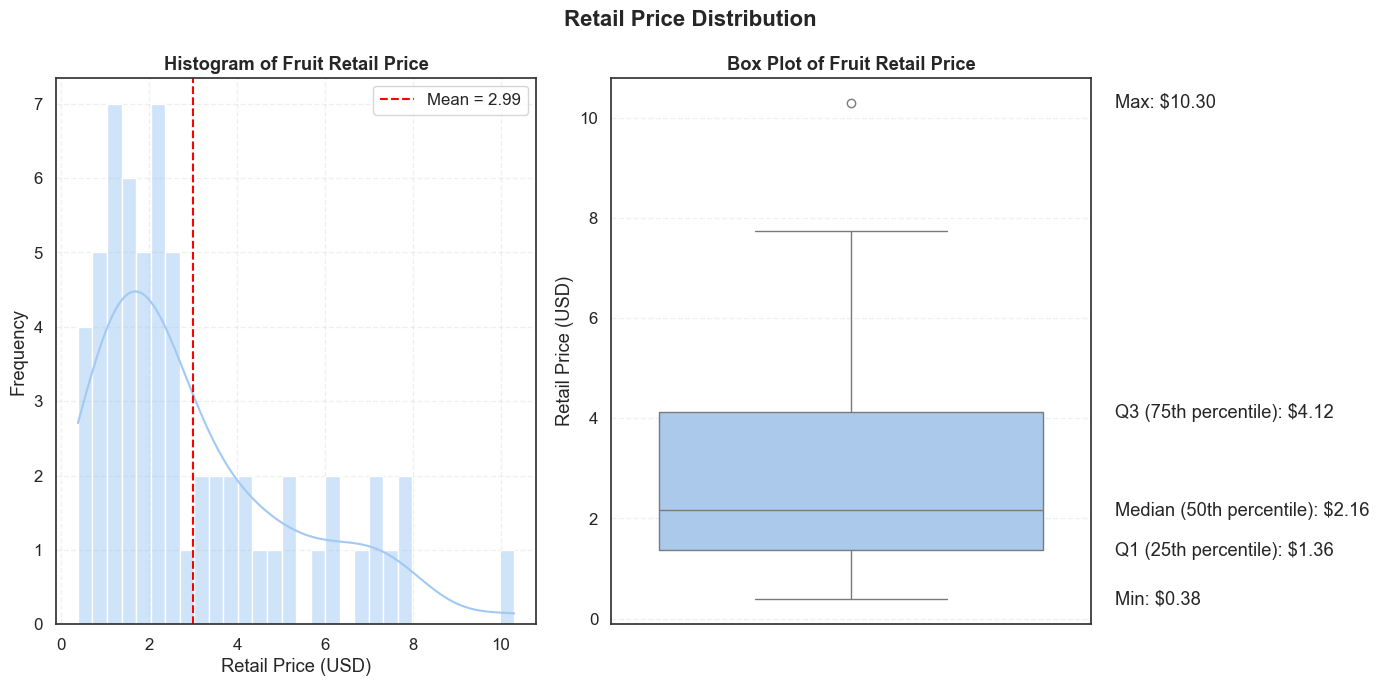

In [214]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# Left panel: distribution
sns.histplot(data=df, x='RetailPrice', bins=30, kde=True,
             ax=axes[0])
axes[0].axvline(stats['Mean'], color='red', linestyle='--',
                label=f'Mean = {stats['Mean']:.2f}')
axes[0].set_xlabel('Retail Price (USD)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Fruit Retail Price')
axes[0].legend()

# Right panel: box plot
sns.boxplot(y=df['RetailPrice'], ax=axes[1])
axes[1].set_ylabel('Retail Price (USD)')
axes[1].set_title('Box Plot of Fruit Retail Price')

# Label value for box plot
label_order = ['Min', 'Q1 (25th percentile)',
               'Median (50th percentile)', 'Q3 (75th percentile)', 'Max']
for label, val in stats.items():
  if label in label_order:
    axes[1].text(
        0.55,
        val,
        f'{label}: ${val:.2f}',
        va='center', ha='left',
    )

fig.suptitle('Retail Price Distribution', fontweight='bold')
plt.tight_layout()
plt.show()

### 🔍 Interpretation:

With two visualizations, they indicates that most products are cheap and clustered at the low price. There are a few expensive products, with the distributon extends toward higher price, which is confirmed by the mean is significantly greater than the median due to the extreme high outlier.

## 📊 Visualization Idea 2: Average Retail Price of Fresh Fruits
The previous visualization allowed us to see the overall retail price distribution among all product forms. To see each distinct fresh fruit's price, we will use an **interactive bar chart with Plotly**. This chart will show the average retail price for each specific fresh fruit and clearly display their names, that way we can easily compare individual fresh fruit cost.  

At first, we need to retrieve retail price for fresh fruits only

In [215]:
# Retrieve retail price for fresh fruits
fresh_retail_price = df.loc[df['Form'] ==
                            'Fresh', ['Fruit', 'Form', 'RetailPrice', 'RetailPriceUnit']]

display(fresh_retail_price)

,Fruit,Form,RetailPrice,RetailPriceUnit
0,Apples,Fresh,1.8541,per pound
4,Apricots,Fresh,3.6162,per pound
8,Bananas,Fresh,0.5971,per pound
10,Blackberries,Fresh,6.7483,per pound
12,Blueberries,Fresh,4.1575,per pound
14,Cantaloupe,Fresh,0.7523,per pound
15,Cherries,Fresh,4.6632,per pound
17,Clementines,Fresh,1.5811,per pound
23,Grapefruit,Fresh,1.4444,per pound
25,Grapes,Fresh,2.0363,per pound


Now, our data is ready for visualization.

In [216]:
# Plotly for bar chart
fig = px.histogram(
    fresh_retail_price, x='Fruit', y='RetailPrice',
    histfunc='avg',
    title='Interactive Bar Chart: Average Retail Price of Different Fruits Forms',
    labels={'RetailPrice': 'Retail Price'},
)
fig.show()

### 🔍 Interpretation:
This visualization clearly reveals the price hierarchy within the fresh fruit category. The five most expensive fresh fruits are: **raspberries, blackberries, cherries, blueberries, and apricots**. Conversely, the five least expensive fresh fruits are: **watermelon, bananas, pineapple, cantaloupe, and honeydew**. This Plotly visualization is utilized because its interactive feature allows us to hover over individual bars to view the precise average price, which static chart can not offer.

# 📊 Visualization Idea 3: Distribution Comparison Charts - Retail Price of Different Forms of Fruits Fresh vs Frozen
In this section, we would compare the retail price of two forms of fruit (Fresh vs Frozen). This visualization may determine if the differences between two forms's means are genuie or due to random sampling variability. 

T-test is a method that I chose to tell whether two groups are statistically different for my findings. Before performing a two-sample t-test to compare retail prices between Fresh and Frozen fruits, we need to calculate basic descriptive statistics:

- Sample Size (n)

- Mean Retail Price

- Standard Deviation (std)

In [ ]:
# Calculate pre test statistics
fresh_prices_summary = df[df['Form'] ==
                          'Fresh']['RetailPrice'].describe()
frozen_prices_summary = df[df['Form'] ==
                           'Frozen']['RetailPrice'].describe()

# Retrieve needed data
pretest_fresh_stats = fresh_prices_summary[[
    'count', 'mean', 'std']].to_frame('Fresh')
pretest_frozen_stats = frozen_prices_summary[[
    'count', 'mean', 'std']].to_frame('Frozen')
pretest_data = pretest_fresh_stats.join(pretest_frozen_stats).T
pretest_data.columns = ['Sample Size', 'Mean', 'Standard Deviation']
tidy_pretest = pretest_data.style.format('{:.2f}')
display(tidy_pretest)

,Sample Size,Mean,Standard Deviation
Fresh,24.00,2.44,1.83
Frozen,6.00,4.34,1.03


Now, we have ready-data to calculate t-statistic followed by this guidelines [Independent Sample T-test](https://www.statisticalaid.com/independent-sample-t-test/)

Python has a built-in function to easily calculate the value with **scipy**

### T-statistics and p-value

In [224]:
from scipy import stats

# Calculate t-statistics and p-value
fresh_prices = df[df['Form'] == 'Fresh']['RetailPrice']
frozen_prices = df[df['Form'] == 'Frozen']['RetailPrice']

res = stats.ttest_ind(
    fresh_prices, frozen_prices, equal_var=False)
t_stat = res.statistic
p_val = res.pvalue
print(f'T-Statistic: {t_stat:.2f}')
print(f'P-Value: {p_val:.4f}')

T-Statistic: -3.36
P-Value: 0.0047


The negative t-statistics value indicates that the mean retail price of the **Frozen** group is higher than the mean retail price of the **Fresh** group.
Since the p-value (0.0047) is less than 0.05, meaning there is only a 0.47% chance of randomly drawing samples that show a price difference as large as (or larger than) the one we found. Therefore, the t-test is statistically significant.  

### Effect Size and Confidence Interval
When we run a t-test, it tells us whether the difference between two groups is real or could have happened by chance.
But to fully understand the results, we also need the **effect size** and the **confidence interval**.  
-  [**Effect size (Cohen’s d)**](https://www.ziaulmunim.com/effect-size-in-independent-samples-t-test/) shows how big or meaningful the difference is.  
Even if a t-test is statistically significant, the actual difference might be very small because the [p-value](https://www.statisticalaid.com/p-value/) is influenced by the sample size, while effect size tells us whether the difference matters in practice.  


- **Confidence interval (CI)** gives us a range in which the true difference between the two population means ($\mu_1 - \mu_2$) is likely to be found with a certain probability (e.g., $95\%$).

Together, **effect size** and **confidence interval** show us:
- how strong the difference is,
- how precise our estimate is, and
- whether the difference is practically important, not just statistically significant.



**Effect Size (Cohen’s d) and 95% Confidence Interval Calculation**  
The Python implementation for the calculation of Cohen's $d$ was adapted from an example found on [AskPython](https://www.askpython.com/python/examples/cohens-d-python).

In [ ]:
# importing numpy for using in-built functions
import numpy as np


def cohens_d(group1, group2):
  # Calculating means of the two groups
  mean1, mean2 = np.mean(group1), np.mean(group2)

  # Calculating pooled standard deviation
  std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
  n1, n2 = len(group1), len(group2)
  pooled_std = np.sqrt(
      ((n1 - 1) * std1 ** 2 + (n2 - 1) * std2 ** 2) / (n1 + n2 - 2))

  # Calculating Cohen's d
  d = (mean1 - mean2) / pooled_std

  return d


# Calculating Cohen's d
effect_size = cohens_d(fresh_prices, frozen_prices)

# 95% confidence interval for difference in means
ci = res.confidence_interval(confidence_level=0.95)
print(f"Cohen's d: {effect_size:.2f}")
print(f"95% CI: ({ci.low:.2f}, {ci.high:.2f})")

Cohen's d: -1.10
95% CI: (-3.11, -0.69)


Cohen’s d (-1.10) suggests a very large practical difference between two groups.  
The 95% CI (-3.11, -0.69) suggests that the true mean is likely a large negative numer, and the range does not cross zero, the difference is statistically significant.  
Therefore, there is both practical and statistically significant between two groups. 

Now, I would plot the **histogram** with the same data to see how it visually prove this evidence.

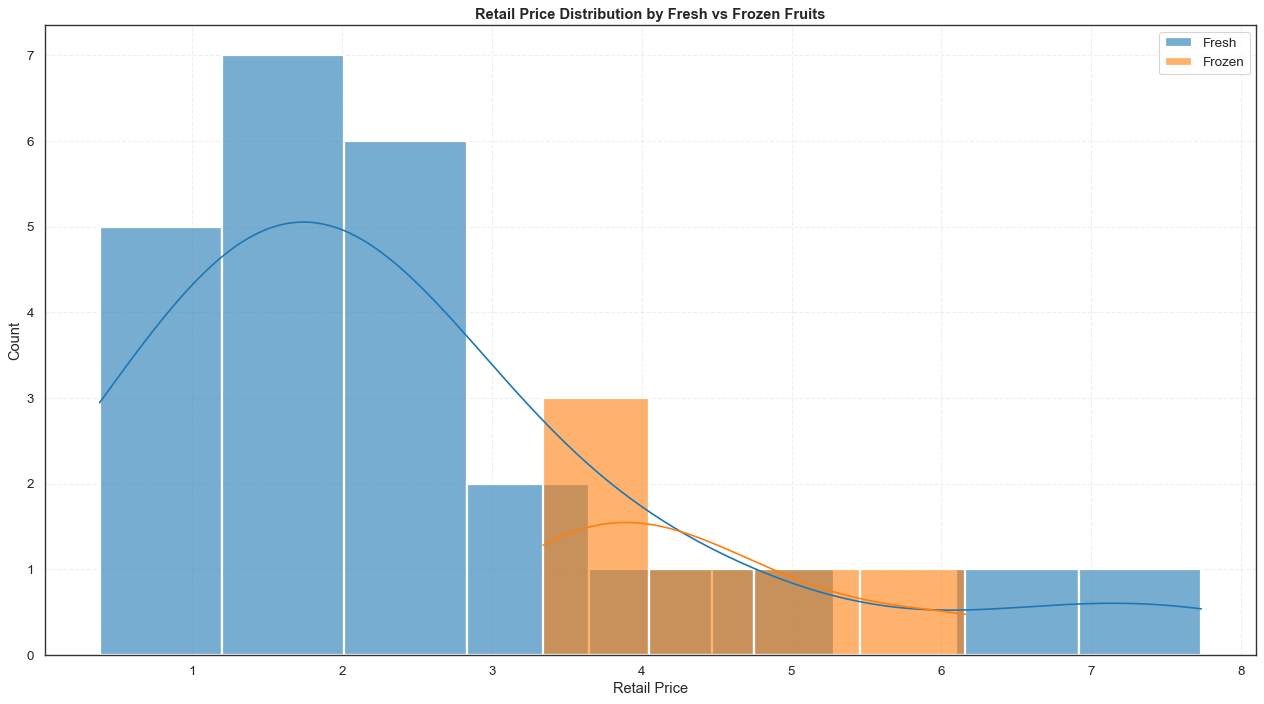

In [198]:
# Plot distributon comparison chart
fig, ax = plt.subplots(figsize=(16, 9), dpi=80)
sns.histplot(x=fresh_prices, kde=True, color='#1f77b4',
             edgecolor='white', linewidth=2, alpha=0.6, label='Fresh')
sns.histplot(x=frozen_prices, kde=True, color='#ff7f0e',
             edgecolor='white', linewidth=2, alpha=0.6, label='Frozen')
ax.set_title('Retail Price Distribution by Fresh vs Frozen Fruits')
ax.set_xlabel('Retail Price')
ax.set_ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

### 🔍 Interpretation:
Based on the visualization, it shows a clear seperation in the central tendency of the two price distributions.  

**Fresh** fruits distribution is centered at a lower retail price. While the **frozen** fruit distribution is center at a higher retail price. This visual difference is confirmed statistically by the independent samples t-test, which produced a negative t-value (indicating **Fresh** < **Frozen**) and a p-value of 0.0047, below the 0.05 significance threshold.

Together, these results provide strong evidence that the retail price of **Frozen** fruit is significantly higher than that of **Fresh** fruit in this dataset. This finding is supported by a very large effect size (-1.10) and a 95% CI of (-3.11, -0.69).

# 📊 Visualization Idea 4: Grouped Bar Chart - Retail Price of Different Fruits in Their Forms


In this section, we'll examine the retail price of 4 different fruits (`Blackberries`, `Blueberries`, `Raspberries`, and `Strawberries`) across their `Fresh` and `Frozen` forms. That way, we will identify whether each fruit and form tends to be cheaper or more expensive than other. 

At first, we need to filter out the four chosen fruits from the `CoreFruit` column.

In [235]:
# Filter specific fruits from dataset
filter_mask = (df['CoreFruit'].str.contains('Blackberries', case=False)
               | df['CoreFruit'].str.contains('Blueberries', case=False)
               | df['CoreFruit'].str.contains('Raspberries', case=False)
               | df['CoreFruit'].str.contains('Strawberries', case=False))
selected_fruits_df = df[filter_mask]
display(selected_fruits_df)

,Fruit,Form,RetailPrice,RetailPriceUnit,Yield,CupEquivalentSize,CupEquivalentUnit,CupEquivalentPrice,CoreFruit
10,Blackberries,Fresh,6.7483,per pound,0.96,0.3197,pounds,2.2471,Blackberries
11,Blackberries,Frozen,4.8277,per pound,1.00,0.3307,pounds,1.5965,Blackberries
12,Blueberries,Fresh,4.1575,per pound,0.95,0.3197,pounds,1.3990,Blueberries
13,Blueberries,Frozen,3.8210,per pound,1.00,0.3307,pounds,1.2636,Blueberries
57,Raspberries,Fresh,7.7338,per pound,0.96,0.3197,pounds,2.5753,Raspberries
58,Raspberries,Frozen,6.1590,per pound,1.00,0.3307,pounds,2.0368,Raspberries
59,Strawberries,Fresh,2.9682,per pound,0.94,0.3197,pounds,1.0094,Strawberries
60,Strawberries,Frozen,3.3421,per pound,1.00,0.3307,pounds,1.1052,Strawberries


From the data we retrieved, these four fruits are only available in `Fresh` and `Frozen` forms, and we can group fruits in `Fresh` form into one group and those in `Frozen` form in another. A **grouped bar chart** will help us compare individual fruit prices within two groups, and also show the general price tendency between two groups.

Here we want to pivot tables to retrieve dataframe that different fruits in different forms will show its retail price, and it can be used to plot our chart

In [234]:
# Pivot so each fruit x form shows its retail price
price_table = selected_fruits_df.pivot_table(
    index='Form',
    columns='CoreFruit',
    values='RetailPrice',
    aggfunc='mean'
)
display(price_table)

CoreFruit,Blackberries,Blueberries,Raspberries,Strawberries
Form,,,,
Fresh,6.7483,4.1575,7.7338,2.9682
Frozen,4.8277,3.8210,6.1590,3.3421


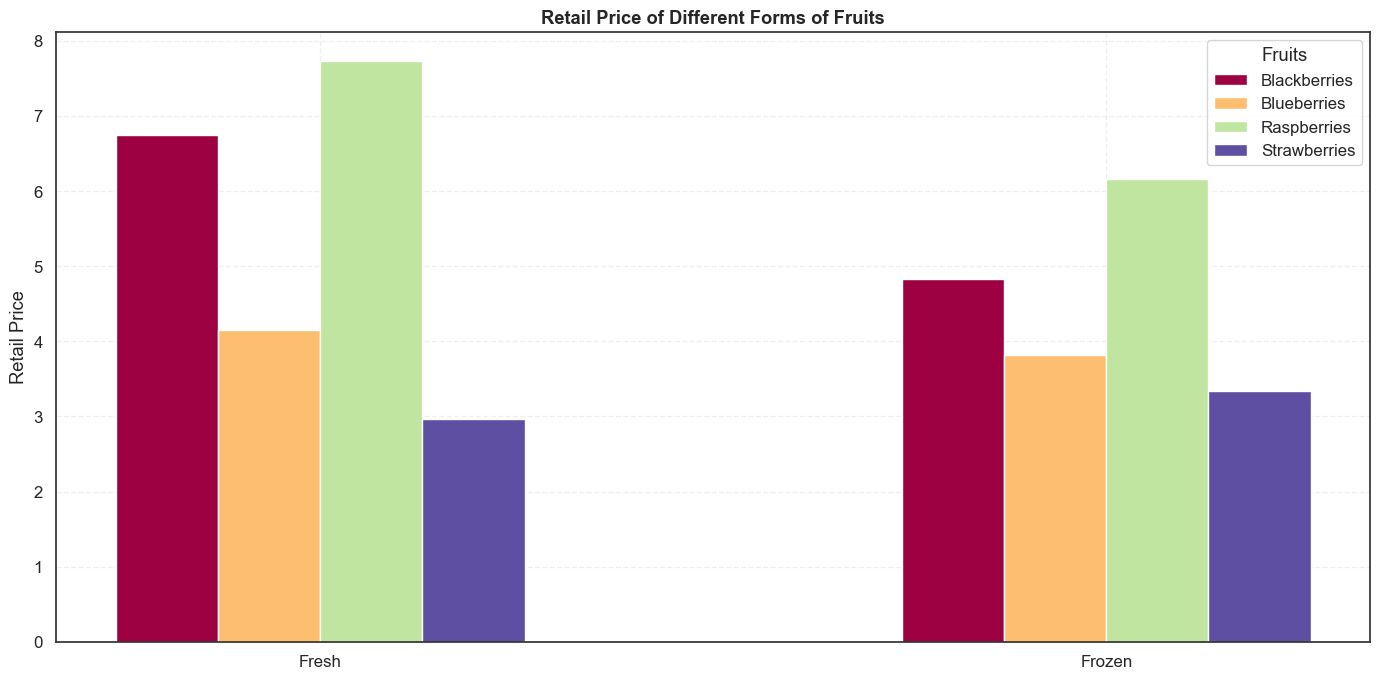

In [ ]:
# Set each fruit position
x = np.arange(len(price_table.index))


bar_width = 0.13

# Create fig and ax
fig, ax = plt.subplots(figsize=(14, 7))

cmap = plt.get_cmap('Spectral', len(price_table.columns))
for i, form in enumerate(price_table.columns):
  ax.bar(x+bar_width*i, price_table[form],
         width=bar_width, color=cmap(i), label=form)

ax.set_xticks(x + bar_width * (len(price_table.columns) - 1) / 2)
ax.set_xticklabels(price_table.index)

ax.set_title('Retail Price of Different Forms of Fruits', fontweight='bold')
ax.set_ylabel("Retail Price")
ax.legend(title="Fruits")
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### 🔍 Interpretation:
This visualization shows that `Raspberries` are the most expensive berry overall, both `Fresh` and `Frozen`. In general, `Fresh` is more exprensive than `Frozen` fruit, while `Strawberries` are the only fruit that costs more when frozen.

## 📊 Visualization Idea 5: Proportion Bar Chart for Price Category and Forms.
In this sec

## 📊 Visualization Idea 5: Retail Price vs Cup Equivalent Price


In [ ]:
retail_price = df['RetailPrice']
cup_price = df['CupEquivalentPrice']
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(data=df, x=retail_price, y=cup_price, ax=ax, scatter_kws={
            'alpha': 0.4, 's': 30}, line_kws={'color': 'red', 'linewidth': '2'})

In [ ]:
retail_price = df['RetailPrice']
cup_price = df['CupEquivalentPrice']
fig = px.scatter(df, x=retail_price, y=cup_price,
                 hover_data=['Fruit', 'Form',
                             'RetailPrice', 'CupEquivalentPrice', ''],
                 labels={'RetailPrice': 'Retail Price',
                         'CupEquivalentPrice': 'Cup Equivalent Price'},
                 title='Interactive Scatter Plot: Retail Price vs Cup Equivalent Price')
fig.update_layout(width=900, height=600)
fig.show()

## 📊 Visualization Idea 4: Yield vs Cup Equivalent Price 

In [ ]:
fruit_yield = df['Yield']
cup_price = df['CupEquivalentPrice']
fig = px.scatter(df, x=fruit_yield, y=cup_price,
                 hover_data=['Fruit', 'Form',
                             'Yield', 'CupEquivalentPrice'],
                 labels={'CupEquivalentPrice': 'Cup Equivalent Price'},
                 title='Interactive Scatter Plot: Yield vs Cup Equivalent Price')
fig.update_layout(width=900, height=600)
fig.show()

## 📊 Visualization Idea 5: Top 5 Most Affordable Fruits


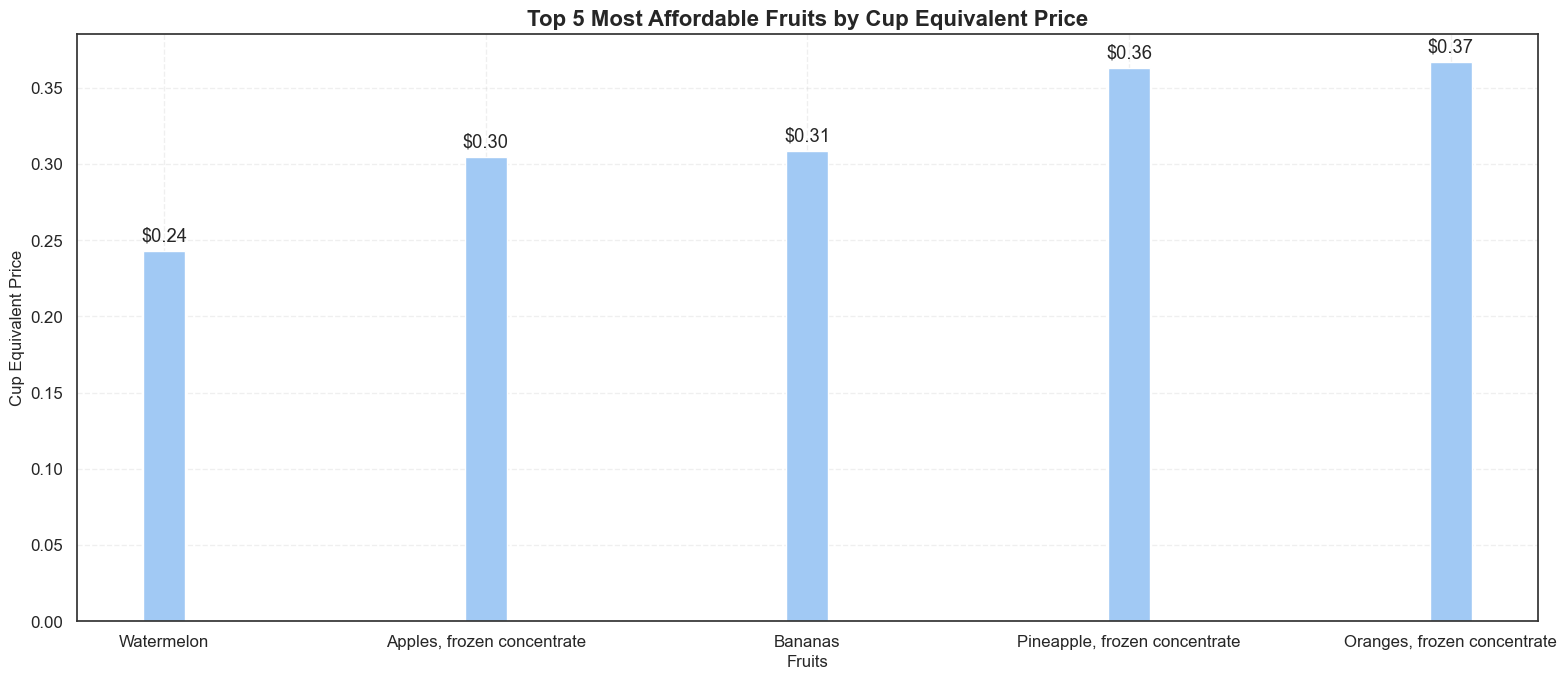

In [138]:
data5 = df[['Fruit', 'CupEquivalentPrice']].sort_values('CupEquivalentPrice')
top5 = data5[:5]
x = np.arange(len(top5.index))

fig, ax = plt.subplots(figsize=(16, 7))
ax.bar(x=top5['Fruit'], width=0.13, height=top5['CupEquivalentPrice'])
ax.set_title(
    'Top 5 Most Affordable Fruits by Cup Equivalent Price', fontsize=16, fontweight='bold')
ax.set_xlabel('Fruits', fontsize=12)
ax.set_ylabel('Cup Equivalent Price', fontsize=12)

for i, price in enumerate(top5['CupEquivalentPrice']):
  ax.text(i, price +
          0.01, f'${price:.2f}', va='center', ha='center')

plt.tight_layout()
plt.show()

## 📊 Visualization Idea 6: Distribution of Fruit Forms


In [ ]:
form_count = df['Form'].value_counts()
form_order = df['Form'].unique().tolist()

fig, ax = plt.subplots(figsize=(10, 7))
ax.pie(form_count, labels=form_order, autopct='%1.1f%%', startangle=90,
       wedgeprops={'edgecolor': 'white',
                   'linewidth': 1.5})
ax.set_title('Distribution of Fruit Forms', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## References
[Indenpendent Sample t-Test: Theory, Application, and Interpretation](https://www.statisticalaid.com/independent-sample-t-test/)  
[Cohen's D Effect Size](https://www.askpython.com/python/examples/cohens-d-python)  
[SciPy Chi-Square](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html)  
[How to Conduct Chi-Square Tests with SciPy](https://www.statology.org/how-to-conduct-chi-square-tests-scipy/)